In [31]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
# nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
#!pip install -U wordcloud

In [19]:
# Importing the training dataset
DATASET_COLUMNS=['id','label','tweet']
df_train = pd.read_csv('https://raw.githubusercontent.com/prateekjoshi565/twitter_sentiment_analysis/master/train_E6oV3lV.csv', names=DATASET_COLUMNS, header=0)
df_train.sample(5)

,id,label,tweet
4172,4173,0,yeah!!! this made my day! thanks @user #win
8347,8348,0,i like your smile :) bogumday
30456,30457,0,i didnt know @user was still around
31565,31566,0,@user ahhhh then let the madness unravel ð...
23376,23377,0,had a curry rice at airside cafeðâ¤ï¸ #lu...


In [20]:
#Length of the dataset

print('length of train data is', len(df_train))
df_train.describe()

length of train data is 31962


,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [21]:
# Importing the Testing dataset
DATASET_COLUMNS=['id','tweet']
df_test = pd.read_csv('https://raw.githubusercontent.com/prateekjoshi565/twitter_sentiment_analysis/master/test_tweets_anuFYb8.csv', names=DATASET_COLUMNS,header=0)
df_test.sample(5)

,id,tweet
11181,43144,#cuteecho with both #grandmas ( #harmony too...
9981,41944,can #lighttherapy help with or #depression? ...
10018,41981,@user the 4th remake of hi-5 doesn't have the ...
9320,41283,and we're in the game!!! installed in minutes ...
83,32046,and the forecast looks good for the weather al...


In [22]:
#Length of the dataset

print('length of test data is', len(df_test))

length of test data is 17197


In [23]:
#Check the number of target values
df_train['label'].unique()

array([0, 1], dtype=int64)

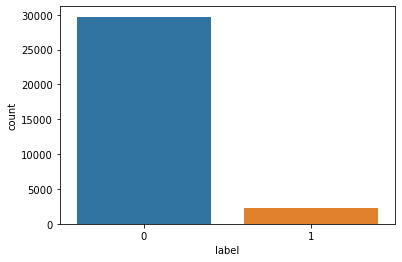

In [28]:
# Plotting the distribution for dataset.
sns.countplot(x='label', data=df_train)
# Storing data in lists.
text, sentiment = list(df_train['tweet']), list(df_train['label'])

## Data Preprocesing

In [29]:

df_train['tweet']=df_train['tweet'].str.lower()
df_train['tweet'].tail()

31957    ate @user isz that youuu?ðððððð...
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960    @user #sikh #temple vandalised in in #calgary,...
31961                     thank you @user for you follow  
Name: tweet, dtype: object

In [36]:
# Removing Stopwords
STOPWORDS = stopwords.words('english')

def cleaning_stopwords(text,STOPWORDS):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df_train['tweet'] = df_train['tweet'].apply(lambda text: cleaning_stopwords(text,STOPWORDS))
df_train['tweet'].head()

0    @user father dysfunctional selfish drags kids ...
1    @user @user thanks #lyft credit can't use caus...
2                                       bihday majesty
3    #model love u take u time urð±!!! ððð...
4                      factsguide: society #motivation
Name: tweet, dtype: object

In [37]:
#Cleaning and removing Punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df_train['tweet']= df_train['tweet'].apply(lambda x: cleaning_punctuations(x))
df_train['tweet'].tail()

31957    ate user isz youuuððððððð...
31958    see nina turner airwaves trying wrap mantle ge...
31959      listening sad songs monday morning otw work sad
31960    user sikh temple vandalised calgary wso condem...
31961                                    thank user follow
Name: tweet, dtype: object

In [38]:
#Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df_train['tweet'] = df_train['tweet'].apply(lambda x: cleaning_repeating_char(x))
df_train['tweet'].tail()

31957    ate user isz youuuððððððð...
31958    see nina turner airwaves trying wrap mantle ge...
31959      listening sad songs monday morning otw work sad
31960    user sikh temple vandalised calgary wso condem...
31961                                    thank user follow
Name: tweet, dtype: object

In [39]:
#Cleaning and removing URL’s
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df_train['tweet'] = df_train['tweet'].apply(lambda x: cleaning_URLs(x))
df_train['tweet'].tail()

31957    ate user isz youuuððððððð...
31958    see nina turner airwaves trying wrap mantle ge...
31959      listening sad songs monday morning otw work sad
31960    user sikh temple vandalised calgary wso condem...
31961                                    thank user follow
Name: tweet, dtype: object

In [40]:
#Cleaning and removing Numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df_train['tweet'] = df_train['tweet'].apply(lambda x: cleaning_numbers(x))
df_train['tweet'].tail()

31957    ate user isz youuuððððððð...
31958    see nina turner airwaves trying wrap mantle ge...
31959      listening sad songs monday morning otw work sad
31960    user sikh temple vandalised calgary wso condem...
31961                                    thank user follow
Name: tweet, dtype: object

In [42]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
df_train['tweet'] = df_train['tweet'].apply(tokenizer.tokenize)
df_train['tweet'].head()

TypeError: expected string or bytes-like object